In [54]:
import json

In [55]:
def get_scores_prompting(task, dataset, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    power, vram, times = [], [], []
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{task}_{dataset}_{data_type}_gemma3:27b_{seed}{'_label' if data_type == 'test' else ''}_{n_shot}_PERFORMANCE.json"
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data)
            power.extend(ex["avg_gpu_power_eval_W"] for ex in data)
            vram.extend(ex["avg_gpu_vram_eval_MB"] for ex in data)
            times.extend(ex["total_time_eval"] for ex in data)

    return {
        "avg_gpu_power_eval_W": sum(power) / len(power),
        "avg_gpu_vram_eval_MB": sum(vram) / len(vram),
        "total_time_eval": sum(times) * 20 / 60, # 60 seconds to minutes
        "n_samples": n_samples * 20 / 5,
        "kWH": ((((sum(power) / len(power)) * sum(times)) * 20)) / (36 * 100000)
    }

def get_scores_prompting_all(task, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_prompting(task, ds, n_shot, base_path, data_type) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }


In [56]:
get_scores_prompting_all("asqp", 50), get_scores_prompting_all("asqp", 50, "../_out_synthetic_examples/01_llm_annotate_train", "train")

({'avg_gpu_power_eval_W': 220.67568475592188,
  'avg_gpu_vram_eval_MB': 19201.974380054056,
  'total_time_eval': 346.0068794886271,
  'n_samples': 448.0,
  'kWH': 1.273089082146471},
 {'avg_gpu_power_eval_W': 222.9056455265581,
  'avg_gpu_vram_eval_MB': 19319.206751650316,
  'total_time_eval': 703.6838806788126,
  'n_samples': 1192.0,
  'kWH': 2.6167181015005334})

In [57]:
def get_scores_laaa(
    task,
    dataset,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    (
        avg_gpu_vram_train_MB,
        avg_gpu_power_train_W,
        total_time_eval,
        total_time_train,
        avg_gpu_vram_eval_MB,
        avg_gpu_power_eval_W,
    ) = ([], [], [], [], [], [])
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{method}_full_{task}_{n_shot}_{dataset}_{seed}_PERFORMANCE.json"
        
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data["all_preds"])
            avg_gpu_vram_train_MB.append(data["avg_gpu_vram_train_MB"])
            avg_gpu_power_train_W.append(data["avg_gpu_power_train_W"])
            total_time_eval.append(data["total_time_eval"])
            total_time_train.append(data["total_time_train"])
            avg_gpu_vram_eval_MB.append(data["avg_gpu_vram_eval_MB"])
            avg_gpu_power_eval_W.append(data["avg_gpu_power_eval_W"])
            
    n_dev = 10 if method == "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit" else 20
    
    return {
        "avg_gpu_vram_train_MB": sum(avg_gpu_vram_train_MB) / 5,
        "avg_gpu_power_train_W": sum(avg_gpu_power_train_W) / 5,
        "total_time_eval": sum(total_time_eval) / 5 / 60 ,
        "total_time_train": sum(total_time_train) / 5 * n_dev / 60,
        "avg_gpu_vram_eval_MB": sum(avg_gpu_vram_eval_MB) / 5,
        "avg_gpu_power_eval_W": sum(avg_gpu_power_eval_W) / 5,
        "n_samples_test": n_samples / 5,
        "kWH_train": (sum(avg_gpu_power_train_W) / 5 * sum(total_time_train) / 5 * n_dev ) / (36 * 100000),
        "kWH_eval": (sum(avg_gpu_power_eval_W) / 5 * sum(total_time_eval) / 5 ) / (36 * 100000),
    }
    
def get_scores_laaa_all(
    task,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_laaa(task, ds, n_shot, method, base_path) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }

In [58]:
get_scores_laaa_all("asqp", 50, "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit")

{'avg_gpu_vram_train_MB': 10393.398623379195,
 'avg_gpu_power_train_W': 220.8926769051392,
 'total_time_eval': 2.543861657301585,
 'total_time_train': 32.59599513689677,
 'avg_gpu_vram_eval_MB': 18302.892413846534,
 'avg_gpu_power_eval_W': 223.11856368638004,
 'n_samples_test': 453.6,
 'kWH_train': 0.12004629321083957,
 'kWH_eval': 0.009462330843404532}

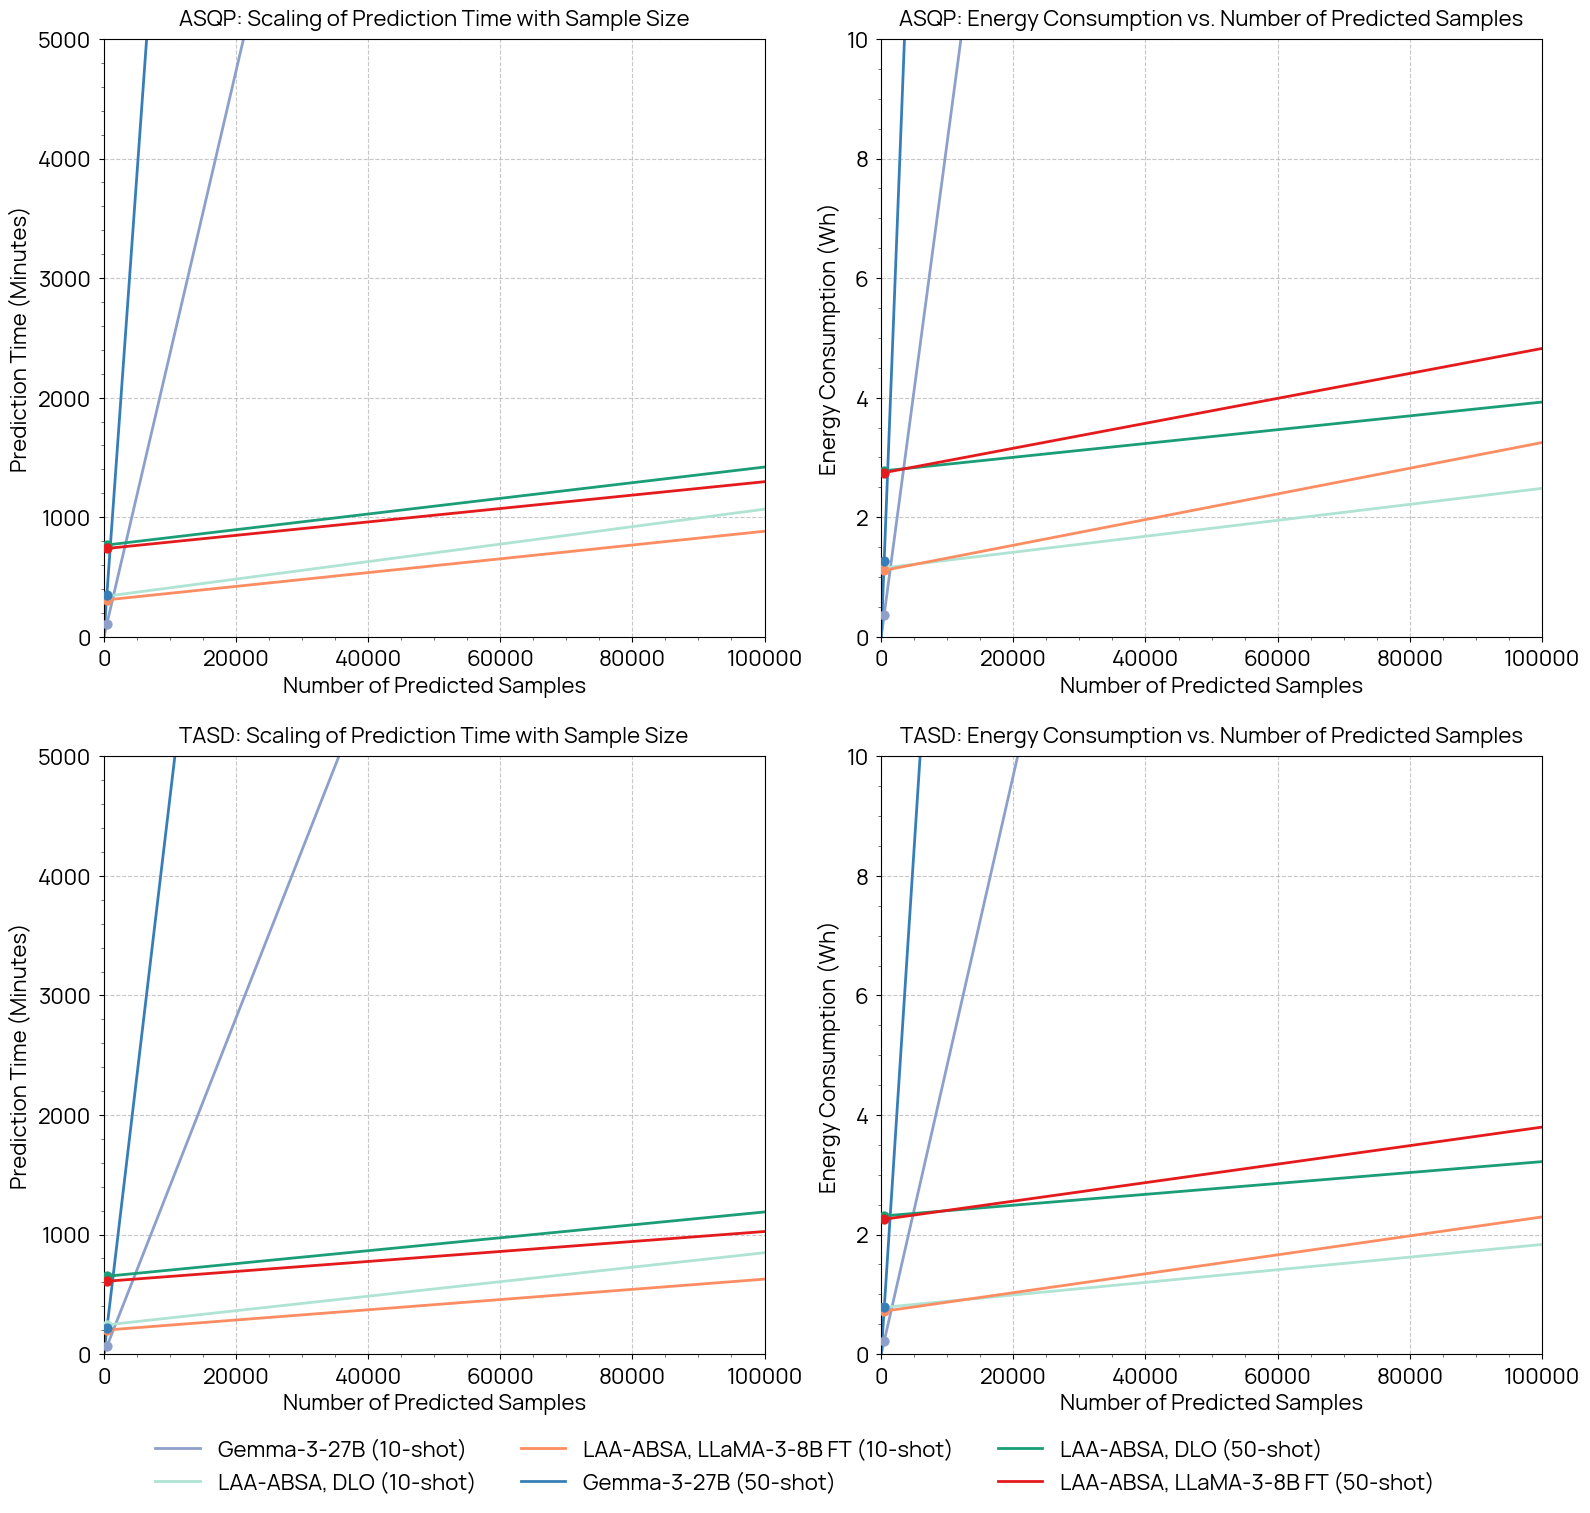

In [59]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

# Globale Variablen für das 2x2 Layout
fig = None
axes = None
subplot_counter = 0
all_handles = []
all_labels = []

def setup_2x2_plot():
    """Initialisiert das 2x2 Plot Layout"""
    global fig, axes, subplot_counter
    
    font_path = '_fonts/Manrope-Regular.ttf'
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = prop.get_name()
    plt.style.use('seaborn-v0_8-paper') 

    fig, axes = plt.subplots(2, 2, figsize=(16, 16), dpi=100)
    subplot_counter = 0
    
    return fig, axes

def draw_plot(title_x, title_y, plot_title, data=[], maximum_y=1000, maximum_x=1000):
    global fig, axes, subplot_counter, all_handles, all_labels
    
    # Wenn noch kein Layout erstellt wurde, erstelle es
    if fig is None:
        setup_2x2_plot()
    
    # Bestimme die Position im 2x2 Grid
    row = subplot_counter // 2
    col = subplot_counter % 2
    ax = axes[row, col]
    
    # Plot die Daten
    for d in data:
        x = np.array(d["x"])
        y = np.array(d["y"])
        
        ax.scatter([x[-1]], [y[-1]], color=d["line_color"], s=50, zorder=5)

        if x[1] > x[0]:
            N_TIMES_SCALE = 1000   
            x[1] = x[1] * N_TIMES_SCALE
            y[1] = y[1] + (y[1] - y[0]) * (N_TIMES_SCALE-1)
         
        line = ax.plot(x, y, color=d["line_color"], linewidth=2, label=d["legend_title_line"])
        
        # Sammle Handles und Labels für die gemeinsame Legende
        if d["legend_title_line"] not in all_labels:
            all_handles.append(line[0])
            all_labels.append(d["legend_title_line"])

    ax.set_xlabel(title_x, fontsize=16)
    ax.set_ylabel(title_y, fontsize=16)
    ax.set_title(plot_title, fontsize=16, pad=10)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.minorticks_on()

    ax.set_xlim(0, maximum_x)
    ax.set_ylim(0, maximum_y)
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    subplot_counter += 1
    
    # Wenn alle 4 Plots erstellt wurden, füge die gemeinsame Legende hinzu und speichere
    if subplot_counter == 4:
        finalize_plot()

def finalize_plot():
    """Fügt die gemeinsame Legende hinzu und speichert das Plot"""
    global fig, all_handles, all_labels
    
    # Gemeinsame Legende unterhalb der Plots
    fig.legend(
        all_handles, 
        all_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.05),
        ncol=3,  # 3 Spalten für bessere Platznutzung
        fontsize=16,
        frameon=False
    )
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, hspace=0.2)  # Platz für die Legende
    plt.savefig("_out_table/prediction_efficiency_plots_2x2.pdf", format="pdf", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Reset für nächste Verwendung
    reset_plot_state()

def reset_plot_state():
    """Setzt den Plot-Status zurück"""
    global fig, axes, subplot_counter, all_handles, all_labels
    fig = None
    axes = None
    subplot_counter = 0
    all_handles = []
    all_labels = []

# Ihr ursprünglicher Code mit kleinen Anpassungen
line_colors = {
    "dlo_10": "#afe3d3",    # heller Türkis
    "dlo_50": "#1b9e77",    # dunkler Türkis
    "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit_10": "#fc8d62",  # helles Korallenrot
    "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit_50": "#e41a1c",  # kräftiges Rot
    "gemma3:27b_10": "#8da0cb",  # helles Blau
    "gemma3:27b_50": "#377eb8",  # kräftiges Mittelblau
}

model_key_to_name = {
    "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit": "LLaMA-3-8B FT",
    "dlo": "DLO"
}

# Beispiel für die Verwendung mit Ihrem Code:
def create_all_plots():
    """Erstellt alle 4 Plots in einem 2x2 Layout"""
    
    for task in ["asqp", "tasd"]:
        # Function to get scores for different configurations
        def get_scores(shot_count, method=None, data_type=None):
            if method is None:
                # Standard prompting
                return get_scores_prompting_all(task, shot_count)
            elif method == "annotate":
                # LLM annotate train
                return get_scores_prompting_all(
                    task,
                    shot_count,
                    base_path="../_out_synthetic_examples/01_llm_annotate_train",
                    data_type="train",
                )
            else:
                # LAAA with specified method (paraphrase or dlo)
                return get_scores_laaa_all(task, shot_count, method)

        # Get scores for all configurations
        configurations = []
        for shot_count in [10, 50]:
            # Standard prompting
            configurations.append({
                "scores": get_scores(shot_count),
                "label": f"Gemma-3-27B ({shot_count}-shot)",
                "color": line_colors[f"gemma3:27b_{shot_count}"]
            })
            
            # LAAA with different methods
            for method in ["dlo", "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit"]:
                annotate_scores = get_scores(shot_count, "annotate")
                method_scores = get_scores(shot_count, method)
                
                configurations.append({
                    "scores": {
                        "annotate": annotate_scores,
                        "method": method_scores
                    },
                    "label": f"LAA-ABSA, {model_key_to_name[method]} ({shot_count}-shot)",
                    "color": line_colors[f"{method}_{shot_count}"]
                })

        # Draw prediction time plot
        plot_data = []
        for config in configurations:
            if "annotate" not in config["scores"]:
                # Standard prompting
                plot_data.append({
                    "x": [0, config["scores"]["n_samples"]],
                    "y": [0, config["scores"]["total_time_eval"]],
                    "legend_title_line": config["label"],
                    "line_color": config["color"],
                })
            else:
                # LAAA methods
                annotate = config["scores"]["annotate"]
                method = config["scores"]["method"]
                plot_data.append({
                    "x": [0, method["n_samples_test"]],
                    "y": [
                        annotate["total_time_eval"] + method["total_time_train"],
                        annotate["total_time_eval"] + method["total_time_train"] + method["total_time_eval"],
                    ],
                    "legend_title_line": config["label"],
                    "line_color": config["color"],
                })
        
        draw_plot(
            "Number of Predicted Samples",
            "Prediction Time (Minutes)",
            f"{task.upper()}: Scaling of Prediction Time with Sample Size",
            plot_data,
            maximum_y=5000,
            maximum_x=100000,
        )

        # Draw energy consumption plot
        plot_data = []
        for config in configurations:
            if "annotate" not in config["scores"]:
                # Standard prompting
                plot_data.append({
                    "x": [0, config["scores"]["n_samples"]],
                    "y": [0, config["scores"]["kWH"]],
                    "legend_title_line": config["label"],
                    "line_color": config["color"],
                })
            else:
                # LAAA methods
                annotate = config["scores"]["annotate"]
                method = config["scores"]["method"]

                plot_data.append({
                    "x": [0, method["n_samples_test"]],
                    "y": [
                        annotate["kWH"] + method["kWH_train"],
                        annotate["kWH"] + method["kWH_train"] + method["kWH_eval"],
                    ],
                    "legend_title_line": config["label"],
                    "line_color": config["color"],
                })
        
        draw_plot(
            "Number of Predicted Samples",
            "Energy Consumption (Wh)",
            f"{task.upper()}: Energy Consumption vs. Number of Predicted Samples",
            plot_data,
            maximum_y=10,
            maximum_x=100000,
        )

# Zum Ausführen rufen Sie einfach auf:
create_all_plots()